# COMP90051 Workshop 5
## Logistic regression in TensorFlow
***
In this worksheet, you'll get some hands-on experience with TensorFlow by implementing logistic regression using the low-level API.
We'll assume you're already familiar with logistic regression from Worksheet 3, although we'll consider the more general case of multi-class classification.
By the end of this worksheet, you should be able to:
* use placeholders to feed data into TensorFlow
* define a simple graph (e.g. to represent the logistic regression model)
* use the built-in optimisers to fit a model

Let's begin by importing the required packages (including TensorFlow).

In [3]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### 1. MNIST data set

MNIST is a multi-class classification data set where:
* the features are images of handwritten digits (28×28 pixels with a single 8-bit channel)
* the target is a label in the set $\{0, 1, \ldots, 9\}$

The data is already split into training and test sets. The training set contains 60,000 instances and the test set contains 10,000 instances.

Below we load the data into NumPy arrays using a built-in function from TensorFlow.

**Question:** How are the arrays structured? Which index is used to access individual instances? What is the type of the arrays? \[Hint: use `array.dtype` to check\]

In [4]:
from tensorflow.keras.datasets import mnist
(images_train, labels_train), (images_test, labels_test) = mnist.load_data()

11493376/11490434 [==============================] - 4s 0us/step


Before using the data for logistic regression, we need to do some basic pre-processing: 
 * We rescale the images so that each pixel is represented as a float between 0 and 1 (note that the images are already normalised)
 * Unroll the 2D image arrays into 1D arrays

In [11]:
print(labels_train.dtype)
print(len(labels_train))


uint8
60000


In [24]:
features_train = np.reshape(images_train.astype('float32')/255, [images_train.shape[0], -1])
features_test = np.reshape(images_test.astype('float32')/255, [images_test.shape[0], -1])
NUM_FEATURES = features_train.shape[1]
NUM_CLASSES = 10

print(features_train[4])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

You can explore the training instances using the code block below.

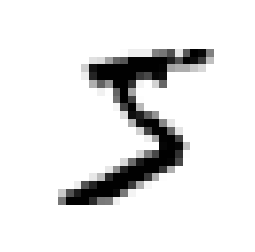

This instance has label 5


In [20]:
train_id = 0 # change this
plt.imshow(images_train[train_id], cmap="binary")
plt.axis('off')
plt.show()
print("This instance has label {}".format(labels_train[train_id]))

### 2. Batching the data
To fit the logistic regression model, we'll be using gradient descent with mini-batches.
In other words, at each iteration we update the parameters using a small sample (mini-batch) of points from the training set.

To make our code more readable, we implement a lightweight wrapper for the training data which returns mini-batches when requested.
This functionality can be implemented elegantly using a Python iterator (see below).

**Note:** For large-scale data (particularly when using a GPU) we recommend using the new Dataset API in Tensorflow (available at `tf.data.Dataset`). 
It can represents a generic input pipeline (which might include batching as well as transformations).

In [21]:
class DatasetIterator:
    """
    An iterator that returns randomized batches from a data set (with features and labels)
    """
    def __init__(self, features, labels, batch_size):
        assert(features.shape[0]==labels.shape[0])
        assert(batch_size > 0 and batch_size <= features.shape[0])
        self.features = features
        self.labels = labels
        self.num_instances = features.shape[0]
        self.batch_size = batch_size
        self.num_batches = self.num_instances//self.batch_size
        if (self.num_instances%self.batch_size!=0):
            self.num_batches += 1
        self._i = 0
        self._rand_ids = None

    def __iter__(self):
        self._i = 0
        self._rand_ids = np.random.permutation(self.num_instances)
        return self
        
    def __next__(self):
        if self.num_instances - self._i >= self.batch_size:
            this_rand_ids = self._rand_ids[self._i:self._i + self.batch_size]
            self._i += self.batch_size
            return self.features[this_rand_ids], self.labels[this_rand_ids]
        elif self.num_instances - self._i > 0:
            this_rand_ids = self._rand_ids[self._i::]
            self._i = self.num_instances
            return self.features[this_rand_ids], self.labels[this_rand_ids]
        else:
            raise StopIteration()

Below we define a batch size and set up an iterator for the training set.

In [25]:
batch_size = 100
train_iterator = DatasetIterator(features_train, labels_train, batch_size)

### 3. TensorFlow placeholders

Placeholders represent tensors in the dataflow graph that will be fed values from outside TensorFlow (e.g. NumPy arrays).

Below we define some placeholders for features and labels.
Note that we've used `None` for the first dimension of both placeholders.
This indicates that the size of the first dimension (i.e. the number of instances) is not fixed.
This allows us to feed in data with varying numbers of instances (e.g. a batch might only have 100 instances, while the test set has 10,000 instances).

In [ ]:
X = tf.placeholder(dtype=tf.float32, shape=[None, NUM_FEATURES], name="features")
Y = tf.placeholder(dtype=tf.uint8, shape=[None,], name="labels")

### 4. Model

We'll shortly specify the logistic regression model as part of the dataflow graph.
However, first we consider how to generalize binary logistic regression to multi-class softmax logistic regression.
***
It's convenient to encode the multi-class labels (corresponding to the digits 0-9) as one-hot vectors.
A one-hot vector has length equal to the number of classes. Whichever class is "active" is set to $1$, while the remaining classes are set to $0$. 

$$
\begin{align}
y = 0 &\to \mathbf{y} = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix} \\
y = 1 &\to \mathbf{y} = \begin{bmatrix}
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix} \\
&\vdots \\
y = 9 &\to \mathbf{y} = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}
\end{align}
$$

For training instance $(\mathbf{x}_i, \mathbf{y}_i)$:

* Define $\mathbf{z}_i = \mathbf{x}_i  \mathbf{W} + \mathbf{b}$ where $\mathbf{W}$ is a `num_features` × `num_classes` weight matrix and $\mathbf{b}$ is a bias vector of length `num_classes`.
* The predicted label is $\hat{y}_i = \arg \max_{j} \sigma(\mathbf{z}_i)_{j}$ where $\sigma(\mathbf{z})_j = \frac {e^{z_{j}}}{\sum _{k=1}^{K} e^{z_{k}}}$ is the softmax function.

The corresponding loss function is the softmax cross-entropy:
$$
L[\mathbf{W}, \mathbf{b}] = - \sum_{i} \mathbf{y}_i \log (\sigma(\mathbf{z}_i))
$$
***

To implement this model in TensorFlow, we need to define Tensor variables to store the weight matrix and the bias vector.
We do this using `tf.get_variable` (although you may see `tf.Variable` used elsewhere).
Note that we had to specify the shape of the tensors, the type, and an initializer (we initialise to zero here).

Once we've defined the variables, we can define additional tensors using TensorFlow operations (e.g. `tf.matmul` for matrix multiplication).
Ultimately, we need to tell TensorFlow how to compute the loss, so that we can minimize it.

In [ ]:
with tf.variable_scope("logistic-regression", reuse=tf.AUTO_REUSE):
    W = tf.get_variable("weights", shape=[NUM_FEATURES, NUM_CLASSES], \
                        dtype=tf.float32, initializer=tf.zeros_initializer())
    b = tf.get_variable("bias", shape=[NUM_CLASSES], dtype=tf.float32, \
                        initializer=tf.zeros_initializer())
    logits = tf.matmul(X, W) + b
    Y_pred = tf.nn.softmax(logits)
    Y_one_hot = tf.one_hot(Y, NUM_CLASSES)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y_one_hot))

### 5. Running gradient descent

Now that we've told TensorFlow how to compute the loss (by defining the `loss` tensor) we can apply a built-in optimizer.

Note that we don't have to specify how to compute the gradient of the loss. This is one of the advantages of expressing the computation as a data flow graph—we can get derivatives using automatic differentiation.

In [ ]:
opt = tf.train.GradientDescentOptimizer(0.01)
opt_operation = opt.minimize(loss)
num_epochs = 50

Below we set up an initializer for the global variables (including `W` and `b`)

In [ ]:
init = tf.global_variables_initializer()

And open a session to run operations on the graph we've defined.

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    #writer = tf.summary.FileWriter("./tensorboard.log", sess.graph) # uncomment to use TensorBoard
    
    # Run gradient descent for multiple epochs
    for epoch in range(num_epochs):
        avg_loss = 0 # average loss over all batches
        for X_batch, Y_batch in train_iterator:
            _, l = sess.run([opt_operation, loss], feed_dict={X: X_batch, Y: Y_batch})
            avg_loss += l / train_iterator.num_batches
        print("Epoch {}: loss={:.9f}".format(epoch, avg_loss))
    print("Optimization complete.")
    
    # Evaluate the trained model
    correct_prediction = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y_one_hot, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy on the test set: {}.".format(accuracy.eval({X: features_test, Y: labels_test})))

### 6. Extension activities
* Experiment with using different built-in optimizers (e.g. `tf.train.AdamOptimizer`) and/or step sizes. Does the rate of convergence vary?
* Try setting up TensorBoard (a web-app that allows you to view the graph and visualize metrics during training).
* Adapt the code in this notebook to implement linear regression (it should only require minimal changes). You'll need to import data that's appropriate for regression.